In [1]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# TODO

- is odeint usage possible? by passing run_step as function (any_object?), instead passing array values?
- is a 3D implementation possible as of now? try!
- can I somehow make this more clearly structured? and easier to add new processes? DOCUMENT CODE WELL! (then share with Benoît)


# NOTES:
### 1. intent is very important! needs to have a proper routing!
"the intent for a variable, i.e., whether the process needs (intent='in'), updates (intent='inout') or computes (intent='out') a value for that variable."

In [2]:
@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.component_label, self.init, 
        
    """
    num = xs.variable(dims=(),intent='in')

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.delta = sum((v for v in self.fluxes)) * dt  #maybe can remove forcing to numpy array here later
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.state += self.delta * self.state
        
    
@xs.process
class Nutrient(Component):
    """"""
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            
@xs.process
class Phytoplankton(Component):
    """"""
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    halfsat = xs.variable(intent='in', dims='P', groups='parameters')
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])

In [3]:
@xs.process
class NutrientUptake:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N)
        self.growth = np.array(nutrient_uptake, dtype='float64')
        self.uptake = np.array(- sum(nutrient_uptake), dtype='float64')

        
@xs.process
class PhytoMortality:
    """"""
    mortality = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    
    def run_step(self):
        self.mortality = - sum(np.array([0.1], dtype='float64')) * self.P
    
@xs.process
class NutrientSource:
    """Chemostat constant nutrient inflow from one direction"""
    supply = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )

    N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.supply = np.array(0.1, dtype='float64')

In [4]:
@xs.process
class ChemostatSetup:
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', dims=[(), 'P'], description='initial Phytoplankton biomass')
    halfsat = xs.variable(intent='in', dims=[(), 'P'], static=True, description='half-saturation constant of nutrient uptake for P')

    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')
    
    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'state', intent='out')
    halfsat_out = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    
    N_init = xs.foreign(Nutrient, 'state', intent='out')

    
    def initialize(self):
        self.P_num_out = self.P_num
        self.halfsat_out = np.array([self.halfsat + i/2 for i in range(self.P_num)], dtype='float64')
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)], dtype='float64')
        self.N_init = np.array([self.N_initVal for i in range(1)], dtype='float64')

In [5]:
mod = xs.Model(
    {
        'ModelSetup':ChemostatSetup,
        'N':Nutrient, 
        'P':Phytoplankton, 
        'N_Uptake':NutrientUptake,
        'P_Mortality':PhytoMortality,
        'N_source':NutrientSource
    }
)

In [6]:
mod

<xsimlab.Model (6 processes, 7 inputs)>
ModelSetup
    N_initVal           [in] initial Nutrient concentration
    P_num               [in] number of Phytoplankton
    P_initVal           [in] () or ('P',) initial Phytoplankton bio...
    halfsat             [in] () or ('P',) half-saturation constant ...
N_source
N_Uptake
N
    component_label     [in]
    num                 [in] number of nutrients (1 by default)
P_Mortality
P
    component_label     [in]

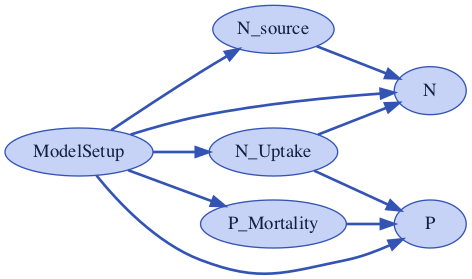

In [7]:
mod.visualize()

In [8]:
#mod.visualize(show_inputs=False, show_variables=True)

In [11]:
in_ds = xs.create_setup(
     model=mod,
     clocks={
         'time': np.linspace(0., 200., 3000)
     },
     master_clock='time',
     input_vars={
         'ModelSetup':{'P_num':2,'P_initVal':1,'halfsat':0.5, 'N_initVal':1}
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [12]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with mod:
        out_ds = in_ds.xsimlab.run()

██████████ 100% | Simulation finished in 00:06 


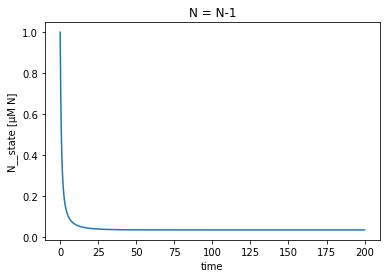

In [13]:
out_ds.N__state.plot()

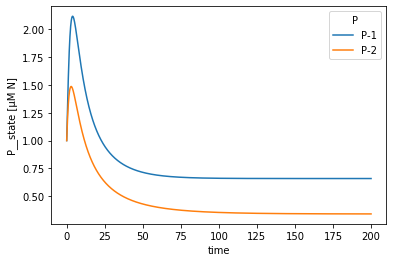

In [14]:
out_ds.P__state.plot.line(x='time')

# now there's two main challenges:
- get odeint to work

- add another dimension (run in 2D grid, and plot animation over time)

## actually both are quite doable
the more expiremental one is for sure odeint, but I have an idea:

with each flux, define an xs.any_object() which is an odeint compatible function of the flux (perhaps necessary for all processes)
this can then be aggregated via xs.group() somewhere else, and solved similarly to what Benoît did in his xsimlab npzd



# okay so the idea is that this calls for a ModelContext object!
that is added to from each flux, and this ModelContext is actually the ODE function!
ideally this would not need additional code, but would grad the run_step (with some accessor @xs.ode or so)

In [2]:
@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.component_label, self.init, 
        
    """
    num = xs.variable(dims=(),intent='in')

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.delta = sum((v for v in self.fluxes)) * dt  #maybe can remove forcing to numpy array here later
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.state += self.delta * self.state
        
    
@xs.process
class Nutrient(Component):
    """"""
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            
@xs.process
class Phytoplankton(Component):
    """"""
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    halfsat = xs.variable(intent='in', dims='P', groups='parameters')
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])

In [3]:
@xs.process
class NutrientUptake:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    _growth = xs.any_object()
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N)
        self.growth = np.array(nutrient_uptake, dtype='float64')
        self.uptake = np.array(- sum(nutrient_uptake), dtype='float64')
        
    def __growth(self,state,time):
        

        
@xs.process
class PhytoMortality:
    """"""
    mortality = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    
    def run_step(self):
        self.mortality = - sum(np.array([0.1], dtype='float64')) * self.P
    
@xs.process
class NutrientSource:
    """Chemostat constant nutrient inflow from one direction"""
    supply = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )

    N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.supply = np.array(0.1, dtype='float64')

In [4]:
@xs.process
class ChemostatSetup:
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', dims=[(), 'P'], description='initial Phytoplankton biomass')
    halfsat = xs.variable(intent='in', dims=[(), 'P'], static=True, description='half-saturation constant of nutrient uptake for P')

    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')
    
    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'state', intent='out')
    halfsat_out = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    
    N_init = xs.foreign(Nutrient, 'state', intent='out')

    
    def initialize(self):
        self.P_num_out = self.P_num
        self.halfsat_out = np.array([self.halfsat + i/2 for i in range(self.P_num)], dtype='float64')
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)], dtype='float64')
        self.N_init = np.array([self.N_initVal for i in range(1)], dtype='float64')

In [5]:
mod = xs.Model(
    {
        'ModelSetup':ChemostatSetup,
        'N':Nutrient, 
        'P':Phytoplankton, 
        'N_Uptake':NutrientUptake,
        'P_Mortality':PhytoMortality,
        'N_source':NutrientSource
    }
)

In [6]:
mod

<xsimlab.Model (6 processes, 7 inputs)>
ModelSetup
    N_initVal           [in] initial Nutrient concentration
    P_num               [in] number of Phytoplankton
    P_initVal           [in] () or ('P',) initial Phytoplankton bio...
    halfsat             [in] () or ('P',) half-saturation constant ...
N_source
N_Uptake
N
    component_label     [in]
    num                 [in] number of nutrients (1 by default)
P_Mortality
P
    component_label     [in]

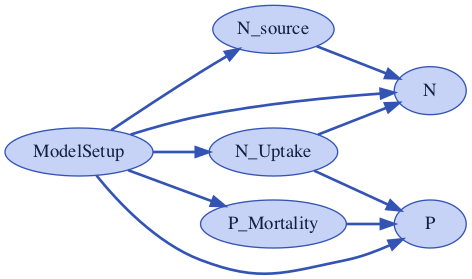

In [7]:
mod.visualize()

In [8]:
#mod.visualize(show_inputs=False, show_variables=True)

In [11]:
in_ds = xs.create_setup(
     model=mod,
     clocks={
         'time': np.linspace(0., 200., 3000)
     },
     master_clock='time',
     input_vars={
         'ModelSetup':{'P_num':2,'P_initVal':1,'halfsat':0.5, 'N_initVal':1}
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [12]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with mod:
        out_ds = in_ds.xsimlab.run()

██████████ 100% | Simulation finished in 00:06 


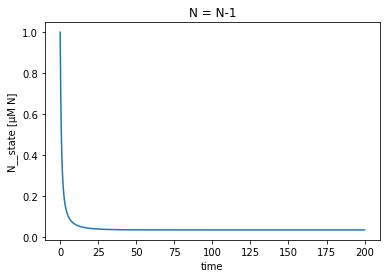

In [13]:
out_ds.N__state.plot()

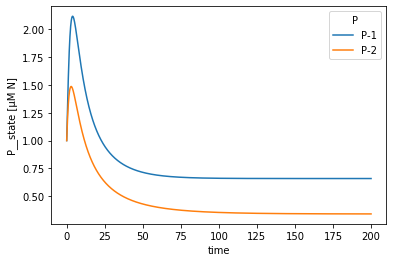

In [14]:
out_ds.P__state.plot.line(x='time')